In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from PIL import Image
import h5py
from tqdm import tqdm

<class 'numpy.ndarray'>


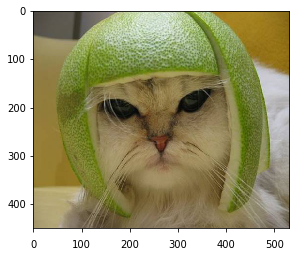

In [5]:
img = Image.open('Cat_Melon.jpg').convert('RGB')
img = np.array(img)/255.0
pl.imshow(img)
var_image = Variable(torch.from_numpy(img.astype('float32')))
var_image_reshape = var_image.view(1, var_image.size(0),var_image.size(1),var_image.size(2))
var_image_reshape = var_image_reshape.transpose(2,3).transpose(1,2)
print(type(img))

torch.Size([1, 3, 451, 531])
(451, 531, 3)


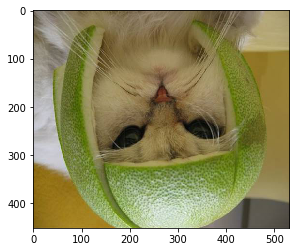

In [64]:
x, y = np.linspace(1,-1,531), np.linspace(1,-1,451)
X, Y = np.meshgrid(x,y)
of = np.transpose(np.expand_dims(np.stack([X,Y]), axis=0),[0,2,3,1])
grid = torch.from_numpy(of.astype('float32'))
out_image = torch.nn.functional.grid_sample(var_image_reshape,grid)
print(out_image.size())
out_image_np = out_image.data.numpy()
out_image_np = np.squeeze(out_image_np)
out_image_np = out_image_np.transpose([1,2,0])
print(out_image_np.shape)
pl.imshow(out_image_np)

(1, 451, 531, 2)


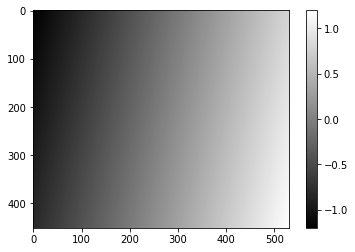

In [11]:
of=grid.data.numpy()
pl.imshow(of[0,:,:,1])
pl.colorbar()
print(of.shape)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, inplanes, outplanes, stride=1, upsample=False, transpose=False):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.transpose = transpose

        if (upsample):
            self.upsample = nn.Upsample(scale_factor=2)
            if (transpose):
                self.conv = nn.ConvTranspose2d(inplanes, outplanes, kernel_size=3, stride=stride, padding=1, output_padding=1)
            else:
                self.conv = nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=1)
        else:
            self.conv = nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=stride)

        self.reflection = nn.ReflectionPad2d(1)
        self.bn = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.bn(x)
        out = self.relu(out)
        
        if (self.upsample):
            out = self.upsample(out)

        out = self.reflection(out)
        out = self.conv(out)
            
        return out
    
class network_optical_flow(nn.Module):
    def __init__(self):
        super(network_optical_flow, self).__init__()
        self.A01 = ConvBlock(2, 64)
        
        self.C11 = ConvBlock(64, 64, stride=2)
        self.C12 = ConvBlock(64, 64)
        self.C13 = ConvBlock(64, 64)
        self.C14 = ConvBlock(64, 64)
        
        self.C21 = ConvBlock(64, 64)
        self.C22 = ConvBlock(64, 64)
        self.C23 = ConvBlock(64, 64)
        self.C24 = ConvBlock(64, 64)
        
        self.C31 = ConvBlock(64, 128, stride=2)
        self.C32 = ConvBlock(128, 128)
        self.C33 = ConvBlock(128, 128)
        self.C34 = ConvBlock(128, 128)
        
        self.C41 = ConvBlock(128, 256, stride=2)
        self.C42 = ConvBlock(256, 256)
        self.C43 = ConvBlock(256, 256)
        self.C44 = ConvBlock(256, 256)
        
        self.C51 = ConvBlock(256, 128, stride=2, upsample=True)
        self.C52 = ConvBlock(128, 128)
        self.C53 = ConvBlock(128, 128)
        self.C54 = ConvBlock(128, 128)
        
        self.C61 = ConvBlock(128, 64, stride=2, upsample=True)
        self.C62 = ConvBlock(64, 64)
        self.C63 = ConvBlock(64, 64)
        self.C64 = ConvBlock(64, 64)
        
        self.C71 = ConvBlock(64, 64, stride=2, upsample=True)
        self.C72 = ConvBlock(64, 2)
        
    def forward(self, x):
        A01 = self.A01(x)
        
        C11 = self.C11(A01)
        C12 = self.C12(C11)
        C13 = self.C13(C12)
        C14 = self.C14(C13)
        C14 += C11
        
        C21 = self.C21(C14)
        C22 = self.C22(C21)
        C23 = self.C23(C22)
        C24 = self.C24(C23)
        C24 += C21
        
        C31 = self.C31(C24)
        C32 = self.C32(C31)
        C33 = self.C33(C32)
        C34 = self.C34(C33)
        C34 += C31
        
        C41 = self.C41(C34)
        C42 = self.C42(C41)
        C43 = self.C43(C42)
        C44 = self.C44(C43)
        C44 += C41
        
        C51 = C34 + self.C51(C44)
        C52 = self.C52(C51)
        C53 = self.C53(C52)
        C54 = self.C54(C53)
        C54 += C51
        
        C61 = C24 + self.C61(C54)
        C62 = self.C62(C61)
        C63 = self.C63(C62)
        C64 = self.C64(C63)
        C64 += C61
        
        C71 = self.C71(C64)
        out = self.C72(C71)
        
        return out
    
class network_spatial_transformer(nn.Module):
    def __init__(self):
        super(network_spatial_transformer, self).__init__()
        
    def forward(self, x, flow):
        flow_reshape = flow.transpose(1,2).transpose(2,3)
        
        out = torch.nn.functional.grid_sample(x, flow_reshape)
        
        return out
    
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = network_optical_flow()
        self.layer2 = network_spatial_transformer()
        
    def forward(self, x):
        
        flow = self.layer1(x)
        out = self.layer2(x[:,0:1,:,:], flow)
        
        return out

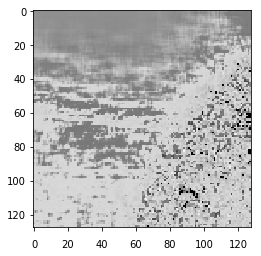

In [13]:
model = network()
image = Variable(torch.randn(1,2,32,32))
image = var_image_reshape[:,0:2,0:128,0:128]
output = model(image)
res = output.data.numpy()
pl.imshow(res[0,0,:,:])

In [41]:
class dataset_h5(data.Dataset):
    def __init__(self, input_file):
        super(dataset_h5, self).__init__()
        self.input_file = input_file
        self.f = h5py.File(self.input_file, 'r')
        self.images = self.f.get("intensity")
        self.n_training, self.nx, self.ny, self.n_times = self.images.shape
        print(self.images.shape)

    def __getitem__(self, index):
        input = np.transpose(self.images[index,0:48,0:48,:],[2,0,1]).astype('float32')
        target = np.transpose(self.images[index,0:48,0:48,1:2],[2,0,1]).astype('float32')

        return input, target

    def __len__(self):
        return self.n_training

In [48]:
class optical_flow(object):
    def __init__(self, batch_size):
        self.cuda = torch.cuda.is_available()
        self.batch_size = batch_size
        model = network()
        if (self.cuda):
            model.cuda()
            
        self.train_file = '/Users/aasensio/deep_learning/database_images.h5'
        self.validation_file = '/Users/aasensio/deep_learning/database_images_validation.h5'
            
        kwargs = {'num_workers': 1, 'pin_memory': True} if self.cuda else {}
        
        self.train_loader = torch.utils.data.DataLoader(dataset_h5(self.train_file),
            batch_size=self.batch_size, shuffle=True, **kwargs)
        
        self.validation_loader = torch.utils.data.DataLoader(dataset_h5(self.validation_file),
            batch_size=self.batch_size, shuffle=True, **kwargs)
        
        self.model = network()
        if self.cuda:
            self.model.cuda()
            
    def optimize(self, epochs, lr=1e-4):
        
        self.lr = lr

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        
        if self.cuda:
            self.loss_fn.cuda()
        
        self.loss = []
        self.loss_val = []
        best_loss = 1e10
        
        for epoch in range(1, epochs + 1):
            self.train(epoch)
            self.test()
            
            is_best = self.loss_val[-1] > best_loss
            best_loss = max(self.loss_val[-1], best_loss)
            save_checkpoint({
                'epoch': epoch + 1,
                #'arch': args.arch,
                'state_dict': self.model.state_dict(),
                'best_loss': best_loss,
                'optimizer' : self.optimizer.state_dict(),
            }, is_best)

    def train(self, epoch):
        self.model.train()
        t = tqdm(self.train_loader)
        for batch_idx, (data, target) in enumerate(t):
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_fn(output, target)
            
            self.loss.append(loss.data.numpy())
            
            loss.backward()
            self.optimizer.step()
            
            t.set_postfix(loss=loss.data[0])

    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        psnr = 0.0
        for data, target in self.test_loader:
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = self.model(data)
            test_loss += self.loss_fn(output, target, size_average=False).data[0] # sum up batch loss
            #psnr = 10 * log10(1 / test_loss.data[0])
            #avg_psnr += psnr

        test_loss /= len(self.test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}'.format(
            test_loss))

In [49]:
optical_flow_network = optical_flow(8)

(30000, 50, 50, 2)
(1000, 50, 50, 2)


In [50]:
optical_flow_network.optimize(1, lr=1e-4)







  0%|          | 0/3750 [00:00<?, ?it/s]





  0%|          | 1/3750 [00:00<51:09,  1.22it/s, loss=0.0215]





  0%|          | 2/3750 [00:01<57:42,  1.08it/s, loss=0.0202]





  0%|          | 3/3750 [00:02<57:57,  1.08it/s, loss=0.0322]





  0%|          | 4/3750 [00:04<1:02:41,  1.00s/it, loss=0.0289]





  0%|          | 5/3750 [00:05<1:08:36,  1.10s/it, loss=0.0239]





  0%|          | 6/3750 [00:06<1:04:44,  1.04s/it, loss=0.0226]





  0%|          | 7/3750 [00:07<1:02:07,  1.00it/s, loss=0.0261]







  0%|          | 8/3750 [00:08<1:04:33,  1.04s/it, loss=0.0239]




  0%|          | 9/3750 [00:09<1:02:49,  1.01s/it, loss=0.0258]




  0%|          | 10/3750 [00:10<1:03:45,  1.02s/it, loss=0.0274]




  0%|          | 11/3750 [00:11<1:02:12,  1.00it/s, loss=0.0234]




  0%|          | 12/3750 [00:12<59:56,  1.04it/s, loss=0.0277]  




  0%|          | 13/3750 [00:13<59:13,  1.05it/s, loss=0.034] 




  0%|          | 14/3750 [00:14<59:46,  1.04it/s, loss=0.02

KeyboardInterrupt: 

In [14]:
print(20*32,29*8)

640 232
